<h1>Прогнозирование оттока клиентов

Из «Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

###### Данное исследование разделим на несколько частей.
* [Шаг 1. Откроем файл с данными и изучим общую информацию](#1-step)
* [Шаг 2. Предобработаем данные и разделим исходные данные на обучающую и тестовую выборки.](#2-step)
* [Шаг 3. Построим модель не учитывая дисбаланс классов.](#3-step)
* [Шаг 4. Исследуем качество разных моделей на сбалансированной выборке.](#4-step)
* [Шаг 5. Проверим качество лучшей модели на тестовой выборке.](#5-step)

<a id='1-step'></a>
<h3>Шаг 1. Откроем файл с данными и изучим общую информацию

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score,make_scorer
from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком:
### Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

### Целевой признак:

- Exited — факт ухода клиента

Посмотрим на общую информацию:

In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце Tenure есть пропуски, видимо эти клиенты не указали свою недвижимость

Построим pairplot для нашего df c начала без разделения на целевую переменную, потом с ней

In [6]:
#sns.pairplot(df);

In [7]:
#sns.pairplot(df,hue='Exited');

Так же посмотрим на корреляцию между количественными переменными:

In [8]:
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Можно заметить, что целевая переменная больше всего коррелирует с возрастом

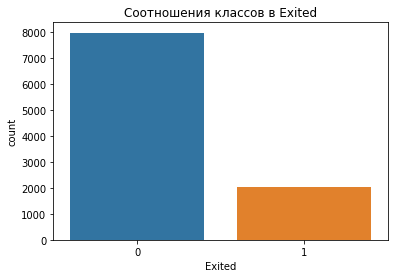

In [9]:
sns.countplot(df.Exited)
plt.title('Соотношения классов в Exited');

У нас явный дисбаланс классов

<a id='2-step'></a>
<h3>Шаг 2. Предобработаем данные и разделим исходные данные на обучающую и тестовую выборки.

<h4>1)Заменим пропуски в столбце Tenure  на отдельный класс: -1, и создадим бинарный признак указывающий на наличие пропуска в этом столбце

In [10]:
new_df=df.copy()

In [11]:
new_df.loc[new_df.Tenure.isna(),'is_Tenure']=1
new_df.loc[~(new_df.Tenure.isna()),'is_Tenure']=0
new_df['Tenure'].fillna(-1,inplace=True)

Посмотрим на изменения:

In [12]:
print(new_df.info())
new_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
 14  is_Tenure        10000 non-null  float64
dtypes: float64(4), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,is_Tenure
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0.0
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0.0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0.0
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0.0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0.0


<h4> 2)Удалим столбец RowNumber, так как это просто номер строки, и он нам не поможет в предсказании. Также удалим Surname и CustomerId, потому что фамилия и Id также не помогут нам в предсказании.

In [13]:
new_df.drop(['RowNumber','Surname','CustomerId'],axis=1,inplace=True)

Проверим изменение:

In [14]:
new_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,is_Tenure
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0.0
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0.0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0.0
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0.0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0.0


<h4>3) Проведем категоризацию данных:

In [15]:
new_df=pd.get_dummies(new_df,drop_first=True)

In [16]:
new_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,is_Tenure,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0.0,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0.0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0.0,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0.0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0.0,0,1,0


 <h4>4) Разделим df на обучающую(60 %), валидационную(20 %) и тренировочную выборку(20 %):

In [17]:
X=new_df.drop(['Exited'],axis=1)
y=new_df.Exited

В наших данных присутствует диссбаланс классов. Попробуем решить задачу с учетом дисбаланса и не учитывая его, сравним результаты.

Не учитывая дисбаланс:

In [18]:
X_train_di, X_test_est, y_train_dis, y_test_est = train_test_split(
X, y, test_size=.4, random_state=12345)

X_test_di, X_valid_di, y_test_dis, y_valid_dis = train_test_split(
X_test_est, y_test_est, test_size=.5, random_state=12345)

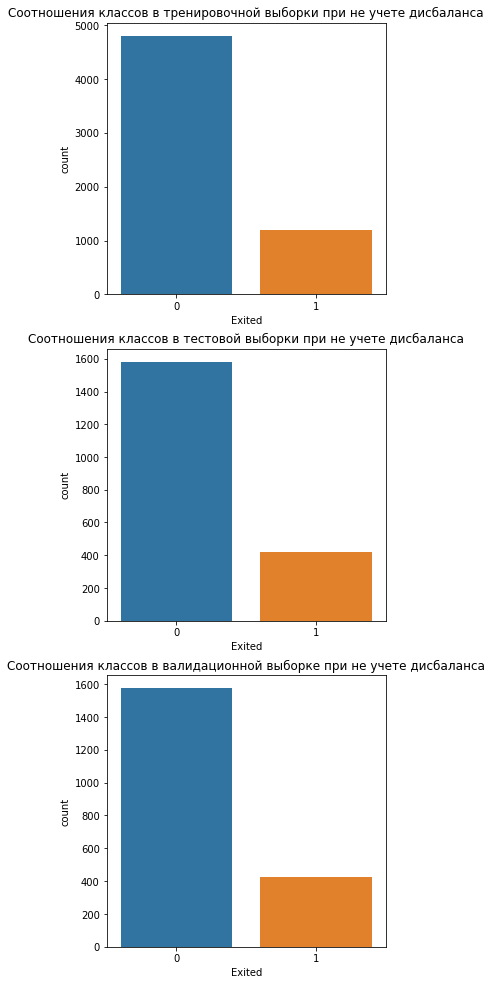

In [19]:
plt.figure(figsize=(5,17))
plt.subplot(3,1,1)
sns.countplot(y_train_dis)
plt.title('Соотношения классов в тренировочной выборки при не учете дисбаланса')
plt.subplot(3,1,2)
sns.countplot(y_test_dis)
plt.title('Соотношения классов в тестовой выборки при не учете дисбаланса');
plt.subplot(3,1,3)
sns.countplot(y_valid_dis)
plt.title('Соотношения классов в валидационной выборке при не учете дисбаланса');

C учетом дисбаланса:

In [20]:
X_train_uns, X_test_est, y_train, y_test_est = train_test_split(
X, y, test_size=.4, random_state=12345,stratify=y)

X_test_uns, X_valid_uns, y_test, y_valid = train_test_split(
X_test_est, y_test_est, test_size=.5, random_state=12345,stratify=y_test_est)

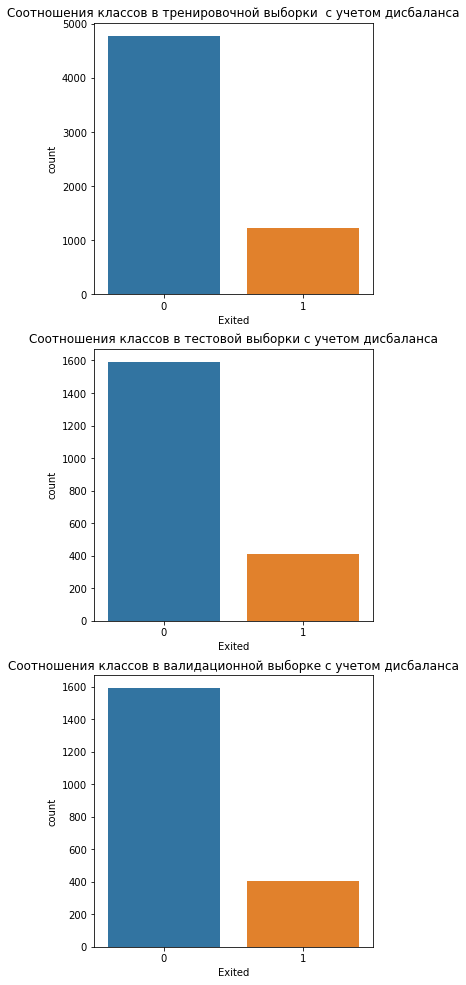

In [21]:
plt.figure(figsize=(5,17))
plt.subplot(3,1,1)
sns.countplot(y_train)
plt.title('Соотношения классов в тренировочной выборки  с учетом дисбаланса')
plt.subplot(3,1,2)
sns.countplot(y_test)
plt.title('Соотношения классов в тестовой выборки с учетом дисбаланса');
plt.subplot(3,1,3)
sns.countplot(y_valid)
plt.title('Соотношения классов в валидационной выборке с учетом дисбаланса');

На взгляд явных отличий от количетсва примеров с классом 1  между стратифицированной и обычной выборкой нет

<h4> 5) Проведем шкалирование:

In [22]:
scaler=StandardScaler()
X_train_dis=pd.DataFrame(scaler.fit_transform(X_train_di),columns=X_train_di.columns)
X_test_dis=pd.DataFrame(scaler.transform(X_test_di),columns=X_test_di.columns)
X_valid_dis=pd.DataFrame(scaler.transform(X_valid_di),columns=X_valid_di.columns)

In [23]:
scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train_uns),columns=X_train_uns.columns)
X_test=pd.DataFrame(scaler.transform(X_test_uns),columns=X_test_uns.columns)
X_valid=pd.DataFrame(scaler.transform(X_valid_uns),columns=X_valid_uns.columns)

Посмотрим на изменения:

In [24]:
X_train_dis.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,is_Tenure,Geography_Germany,Geography_Spain,Gender_Male
0,-0.886751,-0.373192,1.083651,1.232271,-0.891560,0.642466,-1.055187,-0.187705,-0.318628,-0.572475,1.728977,0.907278
1,0.608663,-0.183385,1.083651,0.600563,-0.891560,-1.556504,-1.055187,-0.333945,-0.318628,-0.572475,-0.578377,-1.102198
2,2.052152,0.480939,-0.452862,1.027098,0.830152,-1.556504,0.947699,1.503095,-0.318628,1.746802,-0.578377,0.907278
3,-1.457915,-1.417129,0.469046,-1.233163,0.830152,0.642466,-1.055187,-1.071061,-0.318628,-0.572475,-0.578377,0.907278
4,0.130961,-1.132419,-0.760164,1.140475,-0.891560,-1.556504,-1.055187,1.524268,-0.318628,1.746802,-0.578377,-1.102198


In [25]:
X_train_dis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6000 non-null   float64
 1   Age                6000 non-null   float64
 2   Tenure             6000 non-null   float64
 3   Balance            6000 non-null   float64
 4   NumOfProducts      6000 non-null   float64
 5   HasCrCard          6000 non-null   float64
 6   IsActiveMember     6000 non-null   float64
 7   EstimatedSalary    6000 non-null   float64
 8   is_Tenure          6000 non-null   float64
 9   Geography_Germany  6000 non-null   float64
 10  Geography_Spain    6000 non-null   float64
 11  Gender_Male        6000 non-null   float64
dtypes: float64(12)
memory usage: 562.6 KB


<a id='3-step'></a>
<h3>Шаг 3. Построим модель не учитывая дисбаланс классов.

In [26]:
 def ROC_AUC(x,y,clf):
    y_pred_prob=clf.predict_proba(x)
    fpr,trp,_=roc_curve(y,y_pred_prob[:,1])
    print('ROC-AUC:',roc_auc_score(y,y_pred_prob[:,1]))
    plt.plot(fpr,trp)
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR');
    return roc_auc_score(y,y_pred_prob[:,1])

Функция выводящая метрики для модели и добавляющая их в отдельную таблицу:

In [27]:
models={}
def inf(x,y,clf,mod_name,params,test):
    pred=clf.predict(x)
    print('Модель:', mod_name)
    print('Параметры модели:',params)
    print('Лучшее значение F1 на кросс валидации тестовых данных:',test)
    roc=ROC_AUC(x,y,clf)
    print('F1 score:',f1_score(y,pred))
    models[mod_name]={'F1 на тестовой':test,'ROC_AUC':roc,'F1':f1_score(y,pred)}
    
    

<h4>Обучим случайный лес не учитывая дисбаланс и подберем лучшие гиперпараметры:

In [28]:
clf_rf = RandomForestClassifier(random_state=12345,n_jobs=-1,min_samples_split =5) 
parametrs={'n_estimators':range(100,500,100),'criterion':['gini', 'entropy']}
grid_clf_rf_dis=GridSearchCV(clf_rf,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_rf_dis.fit(X_train_dis,y_train_dis)
best_clf_rf_dis=grid_clf_rf_dis.best_estimator_

Модель: Случайный лес без учета дисбаланса
Параметры модели: {'criterion': 'gini', 'n_estimators': 300}
Лучшее значение F1 на кросс валидации тестовых данных: 0.5654212108049932
ROC-AUC: 0.8536250264214753
F1 score: 0.5325264750378216


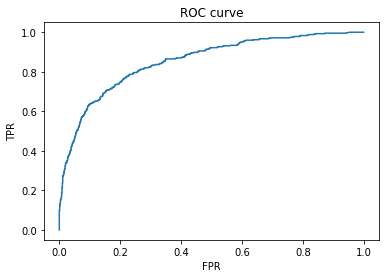

In [29]:
inf(X_valid_dis,y_valid_dis,best_clf_rf_dis,'Случайный лес без учета дисбаланса',grid_clf_rf_dis.best_params_,grid_clf_rf_dis.best_score_)

Значение F1 низкое

Посмотрим там же на ROC кривую и площадь под ней:

Значение ROC-AUC в целом довольно таки высокое

<a id='4-step'></a>
<h3> Шаг 4. Исследуем качество разных моделей на сбалансированной выборке.

Будем обучать модели на 3х типах данных( стратифицированной , oversampling и ADASYN ) и сравним качетсво:

Проведем стандартный oversampling:

In [30]:
def oversample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled)
    
    return features_upsampled, target_upsampled

In [31]:
x_train_over,y_train_over=oversample(X_train, y_train.reset_index(drop=True),4)

In [32]:
y_train_over.value_counts()

1    4888
0    4778
Name: Exited, dtype: int64

Проведем ADASYN:

In [33]:
ada = ADASYN(sampling_strategy='minority', random_state= 420 , n_neighbors = 5)
x_train_ADASYN,y_train_ADASYN = ada.fit_resample(X_train,y_train)

In [34]:
y_train_ADASYN.value_counts()

1    4999
0    4778
Name: Exited, dtype: int64

Теперь у нас сбалансированные классы

<h4>Обучим логистическую регрессию на данных с oversampling, без и ADASYN:

In [35]:
clf_lr = LogisticRegression(random_state=12345) 
parametrs={'penalty':['l1', 'l2'],'class_weight':['balanced', None]}
grid_clf_lr=GridSearchCV(clf_lr,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_lr.fit(X_train,y_train)
best_clf_lr=grid_clf_lr.best_estimator_

Модель: Логистическая регрессия без oversampling
Параметры модели: {'class_weight': 'balanced', 'penalty': 'l2'}
Лучшее значение F1 на кросс валидации тестовых данных: 0.4862845265544145
ROC-AUC: 0.7541115846200593
F1 score: 0.4765217391304348


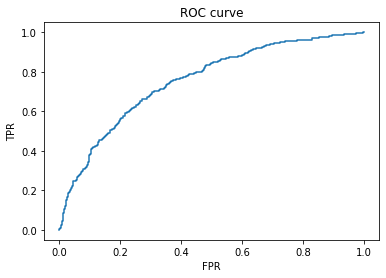

In [36]:
inf(X_valid,y_valid,best_clf_lr,'Логистическая регрессия без oversampling',grid_clf_lr.best_params_,grid_clf_lr.best_score_)

F1 score все еще маленький

In [37]:
clf_lr_over = LogisticRegression(random_state=12345) 
parametrs={'penalty':['l1', 'l2'],'class_weight':['balanced', None]}
grid_clf_lr_over=GridSearchCV(clf_lr_over,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_lr_over.fit(x_train_over,y_train_over)
best_clf_lr_over=grid_clf_lr_over.best_estimator_

Модель: Логистическая регрессия c oversampling
Параметры модели: {'class_weight': None, 'penalty': 'l2'}
Лучшее значение F1 на кросс валидации тестовых данных: 0.6997514872871631
ROC-AUC: 0.7541902457156695
F1 score: 0.4786324786324787


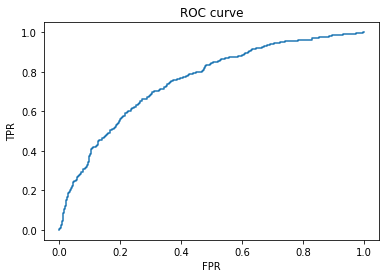

In [38]:
inf(X_valid,y_valid,best_clf_lr_over,'Логистическая регрессия c oversampling',grid_clf_lr_over.best_params_,grid_clf_lr_over.best_score_)

Качество на валидационной выборке упало по сравнению с данными без oversampling(

In [39]:
clf_lr_ADASYN = LogisticRegression(random_state=12345) 
parametrs={'penalty':['l1', 'l2'],'class_weight':['balanced', None]}
grid_clf_lr_ADASYN=GridSearchCV(clf_lr_over,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_lr_ADASYN.fit(x_train_ADASYN,y_train_ADASYN)
best_clf_lr_ADASYN=grid_clf_lr_ADASYN.best_estimator_

Модель: Логистическая регрессия c ADASYN
Параметры модели: {'class_weight': None, 'penalty': 'l2'}
Лучшее значение F1 на кросс валидации тестовых данных: 0.6831586518340828
ROC-AUC: 0.7501970383326316
F1 score: 0.46955128205128205


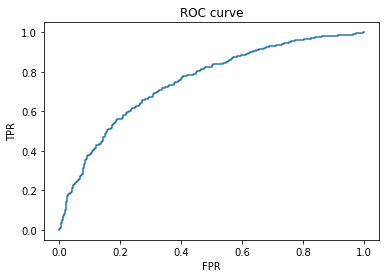

In [40]:
inf(X_valid,y_valid,best_clf_lr_ADASYN,'Логистическая регрессия c ADASYN',grid_clf_lr_ADASYN.best_params_,grid_clf_lr_ADASYN.best_score_)

<h4>Обучим случайный лес на данных с oversampling, без и ADASYN:

In [41]:
clf_rf = RandomForestClassifier(random_state=12345,n_jobs=-1,min_samples_split =5) 
parametrs={'n_estimators':range(100,500,100),'criterion':['gini', 'entropy'],'min_samples_leaf':range(1,7)}
grid_clf_rf=GridSearchCV(clf_rf,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_rf.fit(X_train,y_train)
best_clf_rf=grid_clf_rf.best_estimator_

Модель: Случаиный лес без oversampling
Параметры модели: {'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 400}
Лучшее значение F1 на кросс валидации тестовых данных: 0.5662922764227641
ROC-AUC: 0.8517408008933434
F1 score: 0.547433903576983


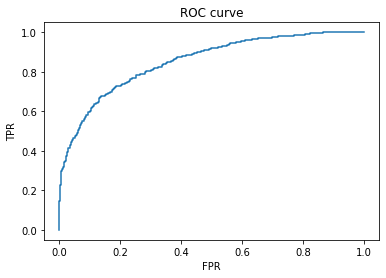

In [42]:
inf(X_valid,y_valid,best_clf_rf,'Случаиный лес без oversampling',grid_clf_rf.best_params_,grid_clf_rf.best_score_)

In [43]:
clf_rf_over = RandomForestClassifier(random_state=12345,n_jobs=-1,min_samples_split =5) 
parametrs={'n_estimators':range(100,500,100),'criterion':['gini', 'entropy'],'min_samples_leaf':range(1,7)}
grid_clf_rf_over=GridSearchCV(clf_rf_over,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_rf_over.fit(x_train_over,y_train_over)
best_clf_rf_over=grid_clf_rf_over.best_estimator_

Модель: Случаиный лес c oversampling
Параметры модели: {'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 400}
Лучшее значение F1 на кросс валидации тестовых данных: 0.9398020462876349
ROC-AUC: 0.8455743879472694
F1 score: 0.5877659574468084


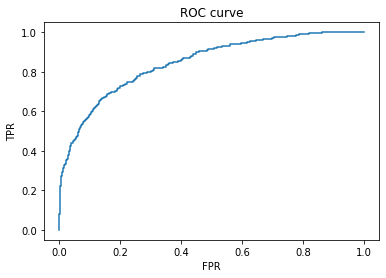

In [44]:
inf(X_valid,y_valid,best_clf_rf_over,'Случаиный лес c oversampling',grid_clf_rf_over.best_params_,grid_clf_rf_over.best_score_)

In [45]:
clf_rf_ADASYN = RandomForestClassifier(random_state=12345,n_jobs=-1,min_samples_split =5) 
parametrs={'n_estimators':range(100,500,100),'criterion':['gini', 'entropy'],'min_samples_leaf':range(1,7)}
grid_clf_rf_ADASYN=GridSearchCV(clf_rf_ADASYN,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_rf_ADASYN.fit(x_train_ADASYN,y_train_ADASYN)
best_clf_rf_ADASYN=grid_clf_rf_ADASYN.best_estimator_

Модель: Случаиный лес c ADASYN
Параметры модели: {'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 400}
Лучшее значение F1 на кросс валидации тестовых данных: 0.8828742640430317
ROC-AUC: 0.84360246224653
F1 score: 0.5808019441069259


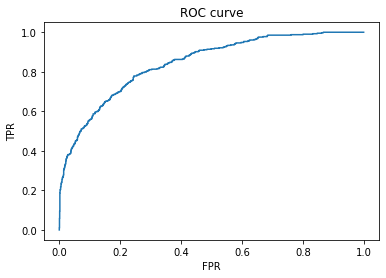

In [46]:
inf(X_valid,y_valid,best_clf_rf_ADASYN,'Случаиный лес c ADASYN',grid_clf_rf_ADASYN.best_params_,grid_clf_rf_ADASYN.best_score_)

<h4>Обучим градиентный бустинг на данных с oversampling, без и с ADASYN :

In [47]:
clf_gb = GradientBoostingClassifier(random_state=12345) 
parametrs={'n_estimators':range(50,300,50),'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
grid_clf_gb=GridSearchCV(clf_gb,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_gb.fit(X_train,y_train)
best_clf_gb=grid_clf_gb.best_estimator_

Модель: Градиентный бустинг без oversampling
Параметры модели: {'learning_rate': 0.1, 'n_estimators': 200}
Лучшее значение F1 на кросс валидации тестовых данных: 0.5805053554547729
ROC-AUC: 0.8577498916481968
F1 score: 0.544049459041731


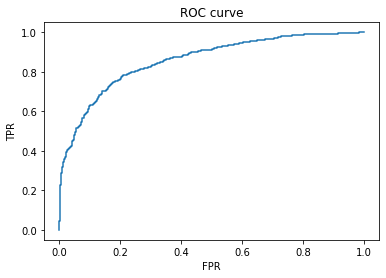

In [48]:
inf(X_valid,y_valid,best_clf_gb,'Градиентный бустинг без oversampling',grid_clf_gb.best_params_,grid_clf_gb.best_score_)

In [49]:
clf_gb_over = GradientBoostingClassifier(random_state=12345) 
parametrs={'n_estimators':range(50,300,50),'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
grid_clf_gb_over=GridSearchCV(clf_gb_over,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_gb_over.fit(x_train_over,y_train_over)
best_clf_gb_over=grid_clf_gb_over.best_estimator_

Модель: Градиентный бустинг с oversampling
Параметры модели: {'learning_rate': 0.3, 'n_estimators': 250}
Лучшее значение F1 на кросс валидации тестовых данных: 0.8732265317488322
ROC-AUC: 0.8294133887354226
F1 score: 0.5683297180043384


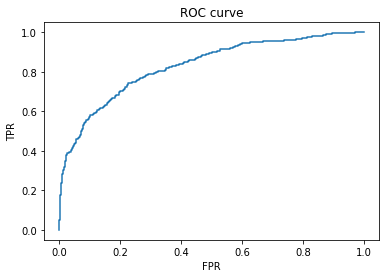

In [50]:
inf(X_valid,y_valid,best_clf_gb_over,'Градиентный бустинг с oversampling',grid_clf_gb_over.best_params_,grid_clf_gb_over.best_score_)

In [51]:
clf_gb_ADASYN = GradientBoostingClassifier(random_state=12345) 
parametrs={'n_estimators':range(50,300,50),'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
grid_clf_gb_ADASYN=GridSearchCV(clf_gb_ADASYN,parametrs,cv=3,scoring=make_scorer(f1_score))
grid_clf_gb_ADASYN.fit(x_train_ADASYN,y_train_ADASYN)
best_clf_gb_ADASYN=grid_clf_gb_ADASYN.best_estimator_

Модель: Градиентный бустинг с ADASYN
Параметры модели: {'learning_rate': 0.2, 'n_estimators': 100}
Лучшее значение F1 на кросс валидации тестовых данных: 0.8428660692254072
ROC-AUC: 0.8537404893337097
F1 score: 0.5856777493606138


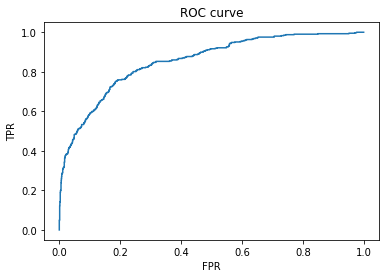

In [52]:
inf(X_valid,y_valid,best_clf_gb_ADASYN,'Градиентный бустинг с ADASYN',grid_clf_gb_ADASYN.best_params_,grid_clf_gb_ADASYN.best_score_)

<h3>Посмотрим на таблицу наших результатов и узнаем какая модель показала себя лучше всего:

In [53]:
score_table=pd.DataFrame.from_dict(data=models,orient='index').sort_values('F1',ascending=False)

In [54]:
score_table

,F1 на тестовой,ROC_AUC,F1
Случаиный лес c oversampling,0.939802,0.845574,0.587766
Градиентный бустинг с ADASYN,0.842866,0.853740,0.585678
Случаиный лес c ADASYN,0.882874,0.843602,0.580802
Градиентный бустинг с oversampling,0.873227,0.829413,0.568330
Случаиный лес без oversampling,0.566292,0.851741,0.547434
Градиентный бустинг без oversampling,0.580505,0.857750,0.544049
Случайный лес без учета дисбаланса,0.565421,0.853625,0.532526
Логистическая регрессия c oversampling,0.699751,0.754190,0.478632
Логистическая регрессия без oversampling,0.486285,0.754112,0.476522
Логистическая регрессия c ADASYN,0.683159,0.750197,0.469551


<h3>Лучше всего себя показал градиентный бустинг обученный на данных с oversampling, его и будем проверять на тестовой выборке

<a id='5-step'></a>
<h3> Шаг 5. Проверим качество лучшей модели на тестовой выборке.

In [55]:
pred=best_clf_gb_over.predict(X_test)

In [56]:
print('F1 score у лучшей модели на тестовой выборке:',f1_score(y_test,pred))

F1 score у лучшей модели на тестовой выборке: 0.6251342642320087
